____
__Universidad Tecnológica Nacional, Buenos Aires__<br/>
__Ingeniería Industrial__<br/>
__Cátedra de Ciencia de Datos - Curso I5521 - Turno sabado mañana__<br/>
__Elaborado por: Martin Palazzo__
____

# Clasificación en dataset Breast Cancer Wisconsin
En el siguiente notebook aplicaremos distintos clasificadores sobre un popular dataset de cancer de mamas. Analizaremos distintas formas de entrenar los modelos y utilizaremos distintos enfoques para evaluar los resultados y seleccionar los hiper-parametros.

#### **Contexto del dataset**
Supongamos que tenemos un set de datos de $n=569$ muestras de tumores, cada una caracterizada por 32 variables de las cuales $d = 31$ de ellas son variables observadas en cada tumor y almacenadas en cada registro. La variable restante $y$ es el diagnostico Benigno (B) o Maligno (M) etiquetado por el especialista en patología. <br>
<br>
Vamos a querer aprender una regla de decisión utilizando métodos de Machine Learning que decida si un tumor es Maligno o Benigno unicamente observando las 31 variables.<br>
<br>
Es decir que aprenderemos una funcion $f(x) = y$ donde $x$ son las variables independientes que caracterizan a cada tumor (features), la función $f(x)$ será utilizada para decidir la categoría $y$ usada para representar la etiqueta del tumor.

Importar las librerias que venimos usando siempre.

In [1]:
# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importamos librerias de scikit-learn

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

### Importamos dataset de Wisconsin Breast Cancer

In [3]:
pwd

'/home/tinto/moi/Ciencia-de-Datos-UTN-FRBA-2023/clase03'

In [4]:
ls

clusterai_2023_clase03_clasificacion_breast.ipynb
clusterai_2023_clase03_clasificacion_iris.ipynb
clusterai_2023_clase03_presentacion.pdf
readme.md


In [6]:
# importamos el dataset con Pandas
# el parámetro index_col indica que la primer columna (la 0) contiene un indicador único por cáda registro
# index_col no será parte del dataset, solo cumplirá la función de índice.
breast = pd.read_csv('dataset_breast_wisconsin.csv', delimiter=';', index_col = 0)


Visualizamos el dataset con Pandas. Observamos que en la columna "diagnosis" se encuentra si el tumor es benigno o maligno. El resto de las columnas refiere a distintas features del tumor. Ver que la primer columna es el ID del paciente, esta información no nos interesa!!

In [7]:
breast.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
# observamos el tamaño del dataset
breast.shape

(569, 31)

# Pre-procesamiento del dataset

Vamos a revisar si existen valores nulos en la tabla que contiene los datos.

In [9]:
# el comando .isnull() de Pandas revisará cada columna para ver si existen o no valores nulos.
breast.isnull().any()

diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_worst             False
fractal_di

**Separo mi variable independiente**: Vamos a guardar en una matriz llamada $x$ las features asociadas a cada muestra. Esta matriz contendra datos que utilizaremos para predecir la cateogira (Maligno-Benigno) de un tumor. Las filas de la matriz representarán cada tumor mientras que las columnas representarán las variables/features.

Inicialmente vamos a crear "x" solamente utilizando las features desde la columna 2 a la 4. Recordemos que en el dataset la columna "diagnosis" no es una variable independiente y solo representaa las etiquetas.

In [11]:
# En esta primera instancia vamos a usar las features 10, 11 , 12 y 13.Para ello realizaremos un filtrado de pandas con .iloc
# en un "slice" el último número no cuenta.
x = breast.iloc[:,10:14]

In [12]:
# con .head() observamos el dataframe resultante
x.head()

,fractal_dimension_mean,radius_se,texture_se,perimeter_se
id,,,,
842302,0.07871,1.0950,0.9053,8.589
842517,0.05667,0.5435,0.7339,3.398
84300903,0.05999,0.7456,0.7869,4.585
84348301,0.09744,0.4956,1.1560,3.445
84358402,0.05883,0.7572,0.7813,5.438


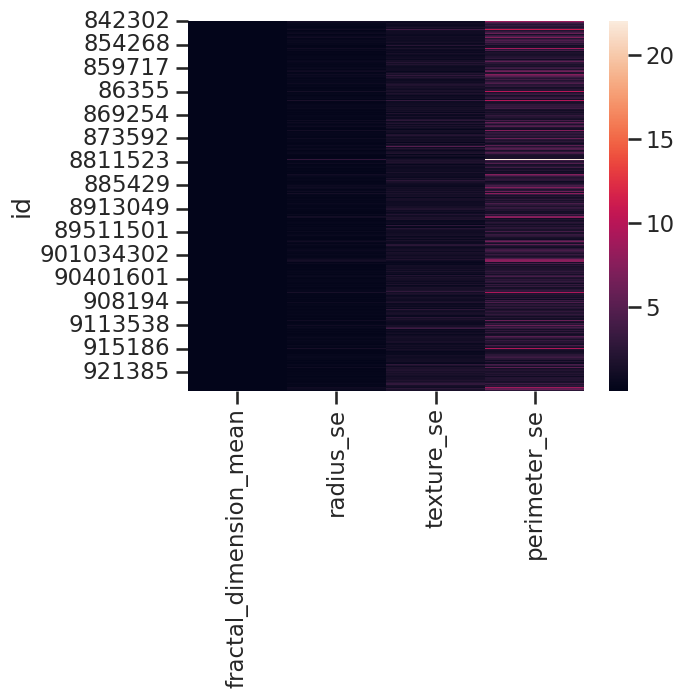

In [13]:
# realizamos un heatmap sobre la matriz X resultante 
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.heatmap(x)
plt.show()

Con un Pairplot vamos a visualizar como se relacionan par-a-par las variables seleccionadas a lo largo de todo el dataset.

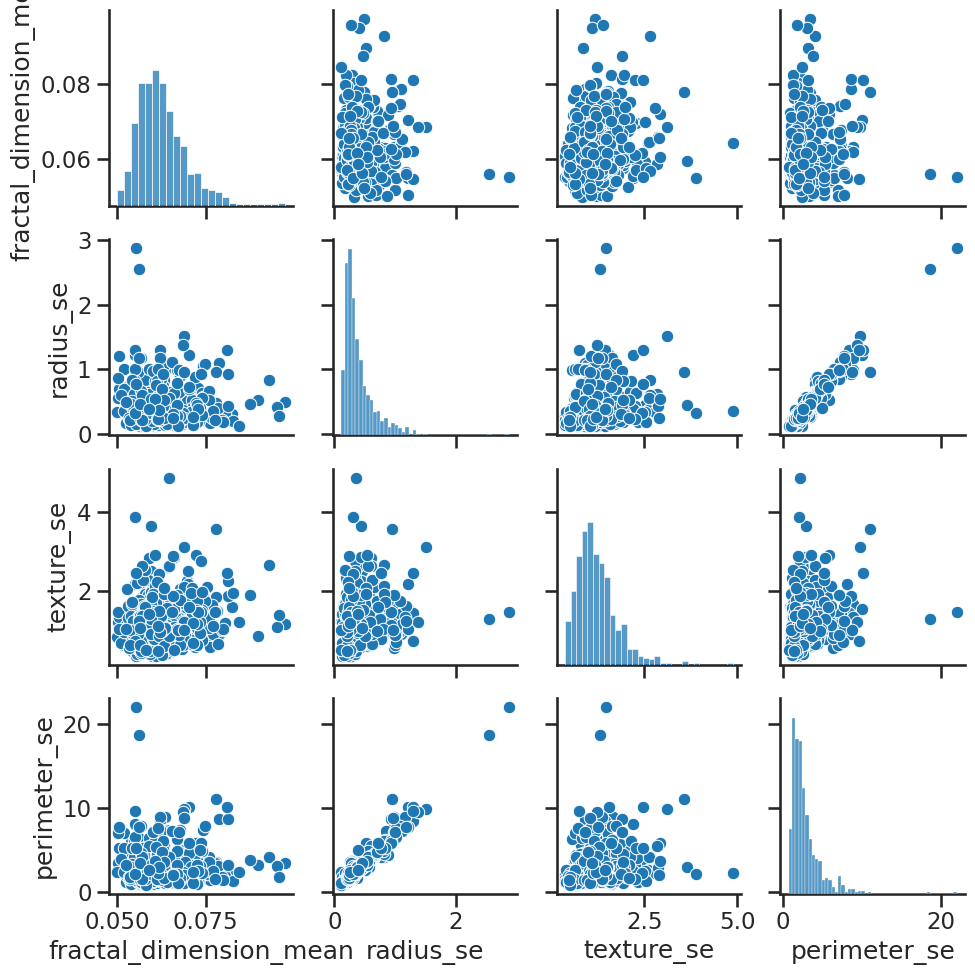

In [14]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.pairplot(x)
plt.show()

In [18]:
# vamos a calcular la correlacion lineal de pearson para las features de nuestro dataset
corr_matrix = x.corr()

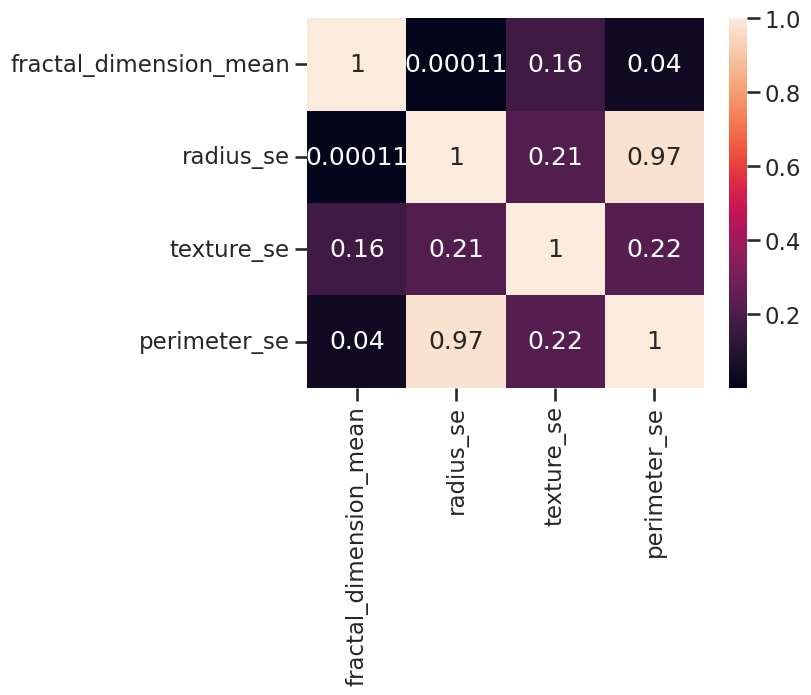

In [19]:
# ademas vamos a visualizar la matriz de correlacion
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
sns.heatmap( corr_matrix ,annot=True)
plt.show()

**Separo mi variable dependiente Y**: Ahora procederemos a crear el vector de etiquetas con las variables dependientes. Ver que las etiquetas se encuentran en la 1er columna (es decir la columna 0) del dataset.

In [24]:
# con .iloc filtramos la primer columna del dataframe para obtener las etiquetas
y = breast.iloc[:,0]

In [26]:
# las etiquetas/labels estan presentadas como categorias y deberiamos pasarlas a una representacion numerica
y.head()

id
842302      M
842517      M
84300903    M
84348301    M
84358402    M
Name: diagnosis, dtype: object

**Transformo mi variable dependiente Y en numerica**: previamente estaba como string.
Vemos que las etiquetas se encuentran asignadas con M y B. Para transformarlas a numéricas utilizaremos el "LabelEncoder" de sklearn y las pasaremos a numeros.

In [27]:
from sklearn import preprocessing
# "le" es el label encoder que transforma las etiquetas de string a INT.
le = preprocessing.LabelEncoder()
# sobre-escribo el vector "y" con las etiquetas numericas obtenidas del label encoder
y=le.fit_transform(y)

In [29]:
# ahora las etiquetas son numericas
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

**Separo mi dataset en Train y Test**:
Con la funcion "train_test_split" de sklearn separaremos nuestro dataset (tanto x como y) en dos sets de entrenamiento y prueba independiente. Podemos elegir que % de muestras esten en cada conjunto. El random_state sirve para que pueda reproducirse la "aleatoriedad" de division de muestras en el futuro. 

In [30]:
# obtenemos xtrain, xtest, ytrain e ytest :) 
# OJO! en este caso estamos usando 95% de test para hacerla mas dificil
# en general el test set es entre 20 y 30% 

xtrain, xtest, ytrain, ytest = train_test_split(x.values, y, test_size=0.95, random_state=4)

In [31]:
# observamos como queda la matriz de xtrain
xtrain.shape

(28, 4)

In [32]:
# observamos como queda la matriz de xtest
xtest.shape

(541, 4)

**Auto-Scaling utilizando muestras de train**: 
Queremos dejar todas las features en los mismos rangos por eso utilizaremos el standard scaler para que queden con media 0 y desvio standard 1.

In [34]:
# auto scaling train- set (mean = 0, std = 1)
# ver que en la misma linea creamos el standard scaler y lo "fiteamos" al mismo tiempo con "xtrain"
scaler = preprocessing.StandardScaler().fit(xtrain)

In [36]:
# xtrain_scal tendra el dataset de train pre-procesado con el standard scaler
xtrain_scal = scaler.transform(xtrain)  

In [39]:
# para cada feature imprimimos la media y el desvio standard obtenido. Ver que media = 0 y stdev = 1.
print("media de cada feature a lo largo del dataset")
print(xtrain_scal.mean(axis=0))
print(" ")
print("Desvio STD de cada feature a lo largo del dataset")
print(xtrain_scal.std(axis=0))

media de cada feature a lo largo del dataset
[-2.29974769e-16  2.37904934e-16 -1.42742960e-16 -1.26882631e-16]
 
Desvio STD de cada feature a lo largo del dataset
[1. 1. 1. 1.]


In [40]:
# observamos en que type quedo xtrain_xcal
type(xtrain_scal)

numpy.ndarray

In [41]:
# utilizando el scaler "fiteado" o "ajustado" a los datos de train, aplicamos el scaler a los datos de test.
# obtenemos "xtest_scal" 
xtest_scal = scaler.transform(xtest)  

In [42]:
# obviamente la media y stdev de las features en test no seran 0 y 1 ya que el scaler se ajusto con train unicamente.
print(xtest_scal.mean(axis=0))
print(xtest_scal.std(axis=0))

[ 0.28725117 -0.18516099 -0.09680347 -0.16105796]
[1.15076156 0.87602068 0.77625392 0.91926177]


Visualizamos la matriz de datos de entrenamiento previo y post a estandarizacion/preprocesamiento con un mapa de calor.

Text(0.5, 1.0, 'Standarized test data')

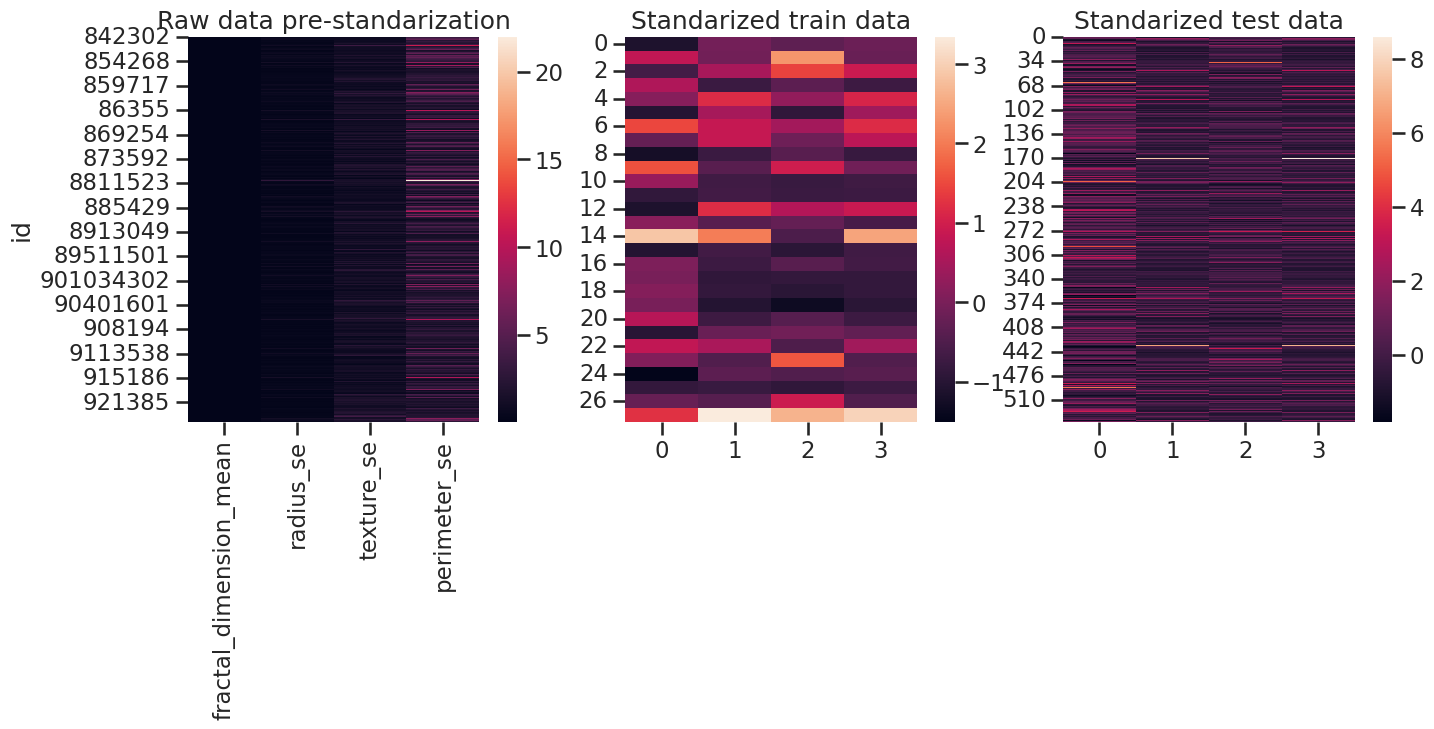

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
sns.heatmap(x, ax = axs[0])
sns.heatmap(xtrain_scal, ax = axs[1])
sns.heatmap(xtest_scal, ax = axs[2])
axs[0].set_title('Raw data pre-standarization')
axs[1].set_title('Standarized train data')
axs[2].set_title('Standarized test data')

Visualizamos la distribucion de las features con boxplots de entrenamiento previo a estandarizacion/preprocesamiento con un boxplot por cada variable.

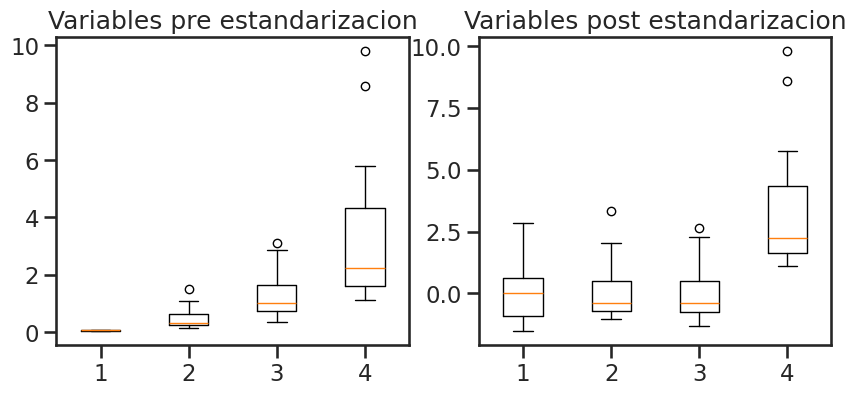

In [45]:
fig, axs = plt.subplots(1, 2,figsize=(10,4))
#plt.figure(figsize=(14,8))
axs[0].boxplot([xtrain[:,0],xtrain[:,1],xtrain[:,2], xtrain[:,3]])
axs[1].boxplot([xtrain_scal[:,0],xtrain_scal[:,1],xtrain_scal[:,2], xtrain[:,3]])
axs[0].set_title('Variables pre estandarizacion')
axs[1].set_title('Variables post estandarizacion')
plt.show()

## Entrenar modelo con Logistic Regression

Defino modelo LR

In [74]:
# defino modelo LR llamado model_lr
# (OJO! no estamos haciendo grid-search)
model_lr = LogisticRegression()


In [75]:
# realizo un cross validation de 5 folds para ver la performance del modelo con distintas particiones de entrenamiento
cv_results = cross_validate(model_lr, xtrain_scal, ytrain, cv=5)

In [76]:
# analizamos los resultados de cada iteracion del cross validation. 
# Este objeto indica el tiempo que tomo cada iteracion, y en "test_score" cuanto dio el resultado de accuracy
cv_results

{'fit_time': array([0.00915527, 0.00438952, 0.00307012, 0.00275731, 0.00226259]),
 'score_time': array([0.00120282, 0.00093627, 0.00084901, 0.00063944, 0.00062013]),
 'test_score': array([1.        , 1.        , 0.83333333, 0.6       , 1.        ])}

In [77]:
# estudiamos como fue el promedio de todos los accuracys a lo largo de todas las iteraciones de cross validation
np.mean(cv_results['test_score'])

0.8866666666666667

Ajusto-entreno (fiteo) modelo a los datos de train. OJO! aca no estamos usando cross-validation. 

In [78]:
# Ajusto mi modelo a las muestras de training utilizando tanto Xtrain como Ytrain
model_lr.fit(xtrain_scal, ytrain) 

LogisticRegression()

Hago prediccion de los datos de test (sin utilizar las etiquetas).

In [79]:
# Genero predicciones con mi modelo entrenado para las muestras de Test, utilizando solo Xtest
ypred = model_lr.predict(xtest_scal)

In [80]:
# visualizamos en pantalla el resultado de las predicciones para cada muestra del conjunto de test
ypred

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,

Computo la exactitud de mi modelo entre las etiquetas de test reales y las asignadas por el modelo.

In [81]:
# Computo el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(ytest, ypred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.7818853974121996


Computamos el Area debajo de la curva ROC del modelo.

In [82]:
#compute and plot AUC
yproba = model_lr.predict_proba(xtest_scal)
fpr1, tpr1, thresholds = roc_curve(ytest.astype('int'), yproba[:,1], drop_intermediate = False)
auc = metrics.auc(fpr1, tpr1)
print("El AUC es = " + str(auc))

El AUC es = 0.8460410557184751


Imprimimos el AUC ROC

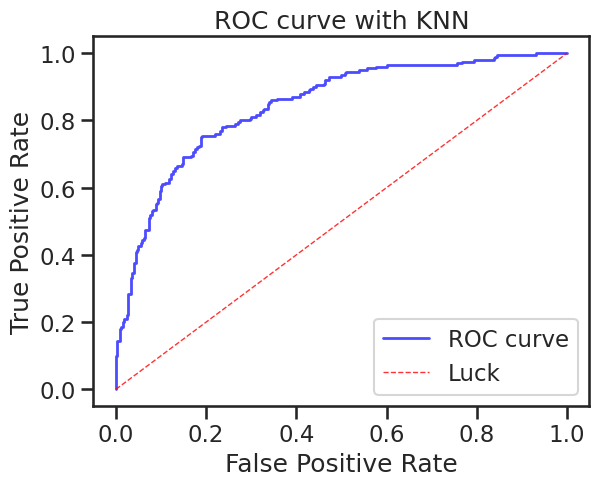

In [83]:
plt.plot(fpr1, tpr1, lw=2, alpha=0.7 , label = 'ROC curve', color = 'b')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',label='Luck', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(False)
plt.legend(loc="lower right")
plt.title('ROC curve with KNN')
plt.show()

Calculamos la matriz de confusión.

In [84]:
# Compute confusion Matrix
cm = confusion_matrix(ytest, ypred)
cm

array([[285,  56],
       [ 62, 138]])

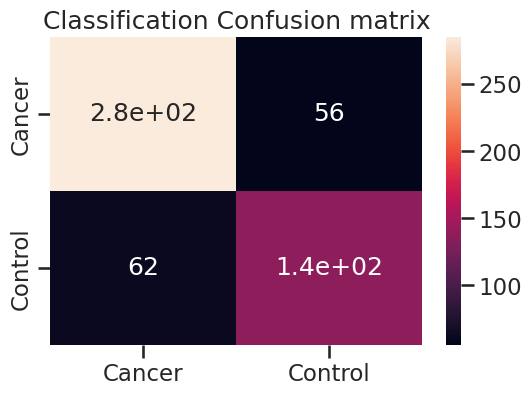

In [85]:
df_cm = pd.DataFrame(cm, index = ['Cancer', 'Control'], columns = ['Cancer', 'Control'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True)
plt.title('Classification Confusion matrix')
plt.show()

# Tarea 01: 
- crear un nuevo set de xtrain y xtest utilizando todas las variables disponibles ya que antes solo habiamos usado un sub-conjunto de las mismas(y asi tener mejor poder de prediccion :)
- Deberan nombrarlas con otro nombre distinto al creado anteriormente y luego comparar resultados de AUC ROC y Accuracy.
- utilizar 70% de train y 30% test.

In [86]:
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############

# Tarea 02: 
- Un SVM con grid search y cross validation cv = 5 utilizando el dataset con todas las features realizado en el punto anterior. 
- Comparar resultados de clasificación entre ambos modelos.
- determinar que parametros son los "ganadores" del grid search para cada modelo.

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100, 1000], 'gamma':[0.0001,0.001, 0.01, 0.1,1, 10,100]}
svc = svm.SVC()
clf_svm = GridSearchCV(svc, param_grid = parameters, refit = True, cv = 5)

In [ ]:
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############

# Tarea 03:
- Entrenar un modelo de logistic regression sobre los datos del punto 01 aplicando cross validation.
- comparar los resultados con el SVM.

In [88]:
from sklearn.linear_model import LogisticRegression
parameters = {'C':[1, 10, 100, 1000]}
lr_model = LogisticRegression(random_state=0, solver='lbfgs')
clf_lr = GridSearchCV(lr_model, param_grid = parameters, refit = True, cv = 5)

In [ ]:
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############

## Tarea 04: Learning courve
¿que sucede si probamos distintos tamaños de train set? ¿como se modificara el accuracy y AUC?
Probar con trainset = <br>
- 5%
- 10%
- 15%
- 20%
- 25%
- ..%
- ..%
- 100%
y comparar para KNN, LR y SVM.

In [ ]:
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############

In [ ]:
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############

In [ ]:
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############
######### CODIGO AQUI ############